In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

Using TensorFlow backend.


# Introduction

> Convolutional Neural Networks (ConvNets or CNNs) are a category of Neural Networks that have proven very effective in areas such as image recognition and classification. ConvNets have been successful in identifying faces, objects and traffic signs apart from powering vision in robots and self driving cars. [1]

Reference:
[1] https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

# Load Data

>Using the built in function ImageDataGenerator to specify a path to our data and so it can feed it into the model.

In [2]:
# Define the input image dimensions
img_rows, img_cols = 50, 50

datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_validation = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen_train.flow_from_directory("Emotion_Detection/" + "train",
                                                    target_size=(img_rows, img_cols),
                                                    color_mode="grayscale",
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    shuffle=True)

test_generator = datagen_validation.flow_from_directory("Emotion_Detection/" + "test",
                                                    target_size=(img_rows, img_cols),
                                                    color_mode="grayscale",
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Data Training with CNN

In [3]:
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and BatchNormalization to improve stabiliy and performance
# and Dropout to reduce overfitting
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (50, 50, 1)))
CNN_model.add(Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))


CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(256, (3, 3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))


CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(7, activation='softmax'))

CNN_model.summary()

CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])



history = CNN_model.fit_generator(generator = train_generator,
                                steps_per_epoch = train_generator.n//train_generator.batch_size,
                                epochs= 20,
                                validation_data = test_generator,
                                validation_steps = test_generator.n//test_generator.batch_size)


## SAVING THE CNN MODEL TO JSON FILE

#emo_fer_json = CNN_model.to_json()
#with open("emo_fer.json", "w") as json_file:
#    json_file.write(emo_fer_json)
#CNN_model.save_weights("emo_fer.h5")
#print('done')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
__________

# Accuracy and Loss Graph

>Refer to the graphs below, it shows that the testing accuracy starts to stabilize after the 13th epochs between 60% and 64% accuracy.  Again, the training loss is becoming much smaller than the testing loss after the 13th epochs. This is because the model itself starts to overfit the training dataset after too much iterations. To prevent overfitting, I can reduce the number epochs. Although, the test accuracy was only slightly higher than 50%, the machine was still able to differentiate more than half of the 7 emotions correctly. Therefore, I would say the result is really satisfying to this demonstration project.

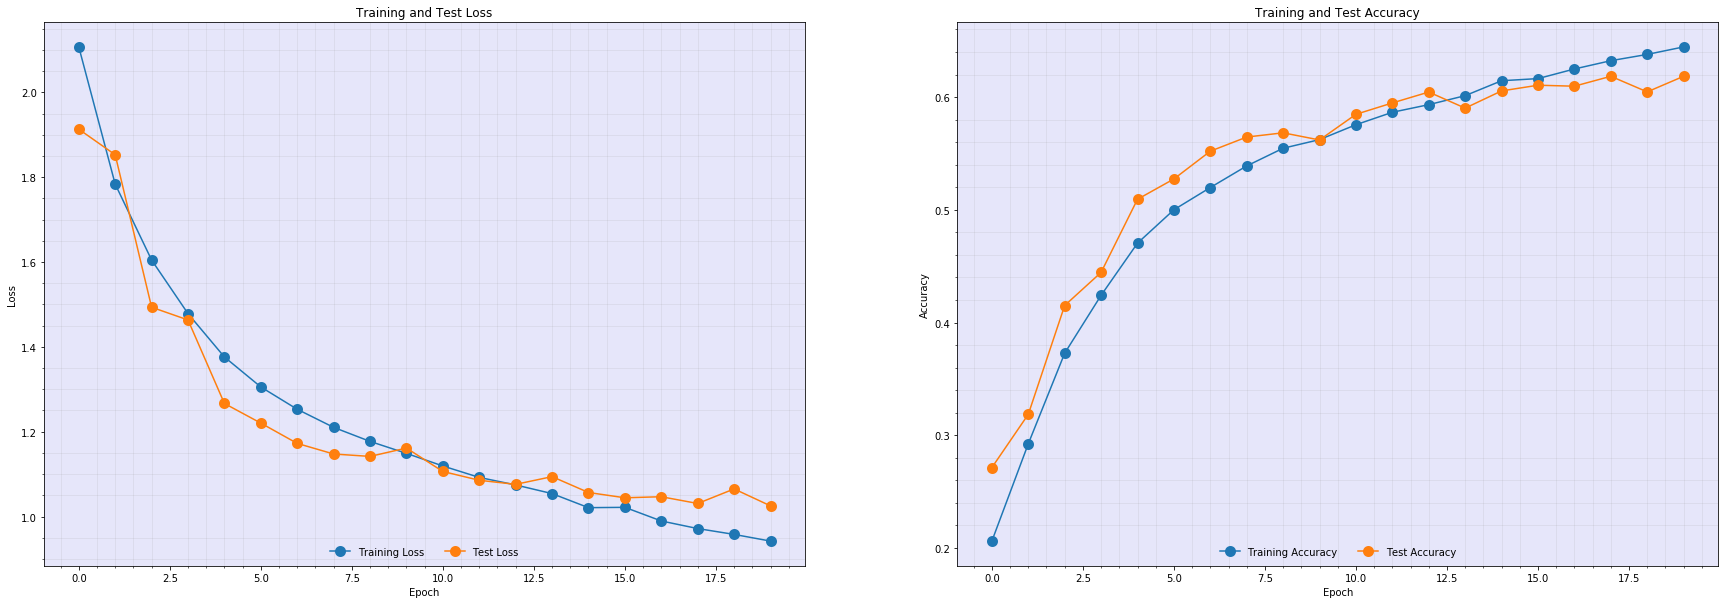

In [4]:
# The Accuracy and Loss Graphs between training and test
fig, ax = plt.subplots(1,2,figsize=(30, 10))

ax[0].plot(history.history['loss'], marker='o', label='Training Loss',markeredgewidth=5)
ax[0].plot(history.history['val_loss'], marker='o', label='Test Loss',markeredgewidth=5)
ax[0].set_title('Training and Test Loss')
ax[0].legend(frameon=False, loc='lower center', ncol=2)
ax[0].set_xlabel('Epoch',)
ax[0].set_ylabel('Loss')
ax[0].grid(color='#666666', linestyle='-.', linewidth=0.7,which='minor')
ax[0].minorticks_on()
ax[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax[0].set_facecolor("#E6E6FA")

ax[1].plot(history.history['acc'], marker='o', label='Training Accuracy',markeredgewidth=5)
ax[1].plot(history.history['val_acc'], marker='o', label='Test Accuracy',markeredgewidth=5)
ax[1].set_title('Training and Test Accuracy')
ax[1].legend(frameon=False, loc='lower center', ncol=2)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid(color='#666666', linestyle='-.', linewidth=0.7,which='minor')
ax[1].minorticks_on()
ax[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax[1].set_facecolor("#E6E6FA")

>Here, I increased the CNN architecture with 5 convolutional layers and 2 Fully connected layers to train the emotion detection model. By adding, batch normalization improved the performance and stability of Neural Network and adding dropout to reduced overfitting. The testing accuracy for emotion detection was around 62%. 

In [5]:
prediction = CNN_model.predict_generator(test_generator)
test_true = test_generator.classes
test_pred = prediction.argmax(axis=1)

In [6]:
print('Test accuracy:', accuracy_score(test_true,test_pred))

Test accuracy: 0.6154825926974243


# Confusion Matrix

In [7]:
Type = ['angry','disgust','fear','happy','neutral','sad','surprise']
con_mat = confusion_matrix(test_true, test_pred)
percentage_con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

In [8]:
normal_df = pd.DataFrame(percentage_con_mat,index = Type,columns =  Type)
percentage_df = pd.DataFrame(con_mat,index = Type,columns =  Type)

>The confusion matrix plots below show that the Emotion Detection model has very significant result for predicting 7 emotions.

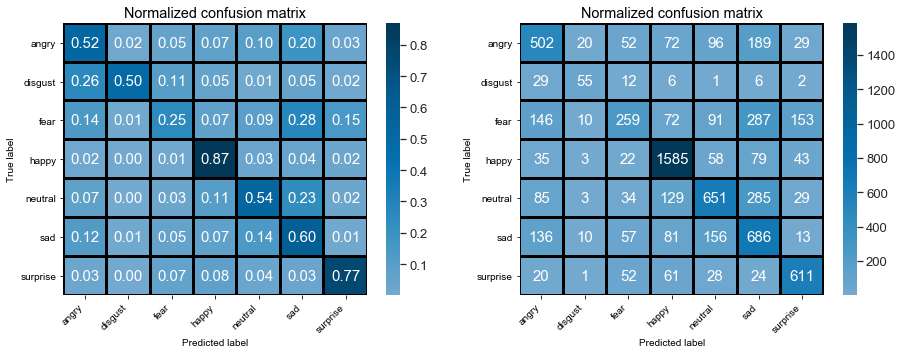

In [9]:
# The Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.set(font_scale=1.2)
plot1 = sns.heatmap(normal_df,center=0,annot=True,fmt = '.2f',linewidths=2,cmap="PuBu",
                    annot_kws={"size": 15},ax=ax[0],linecolor='black')
plot1.set_title('Normalized confusion matrix')
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right');
plot1.set_yticklabels(plot1.get_yticklabels(), rotation=0, horizontalalignment='right');
plot1.set_ylabel('True label');
plot1.set_xlabel('Predicted label');

plot2 = sns.heatmap(percentage_df,center=0,annot=True, fmt="d",linewidths=2,cmap="PuBu",
                    annot_kws={"size": 15},ax=ax[1],linecolor='black')
plot2.set_title('Normalized confusion matrix')
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right');
plot2.set_yticklabels(plot2.get_yticklabels(), rotation=0, horizontalalignment='right');
plot2.set_ylabel('True label');
plot2.set_xlabel('Predicted label');

# Image Testing

>Using Haar Cascade Classifier, it helps remove the background noise and crop the frontal face image.

In [10]:
def faceDetection(test_img):
    gray_img= test_img 
    face_haar_cascade=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces=face_haar_cascade.detectMultiScale(gray_img,scaleFactor=1.32,minNeighbors=5)

    return faces,gray_img

In [11]:
path1 = 'Emotion_Test/IMG_3626.jpg'
path2 = 'Emotion_Test/angry face.jpg'
path3 = 'Emotion_Test/Dacre-Montgomery-poster_2982460_b.jpg'
path4 = 'Emotion_Test/r1450056_21061191.jpg'
path5 = 'Emotion_Test/b27df2700e65924f1f70ab266ebf83cd.jpg'
path6 = 'Emotion_Test/6dfb5660c821203ebfc479951993a0a3.jpg'
path7 = 'Emotion_Test/d50f38c61b29bbecdaf63075ca4d39b8.jpg'

path = [path1,path2,path3,path4,path5,path6,path7]

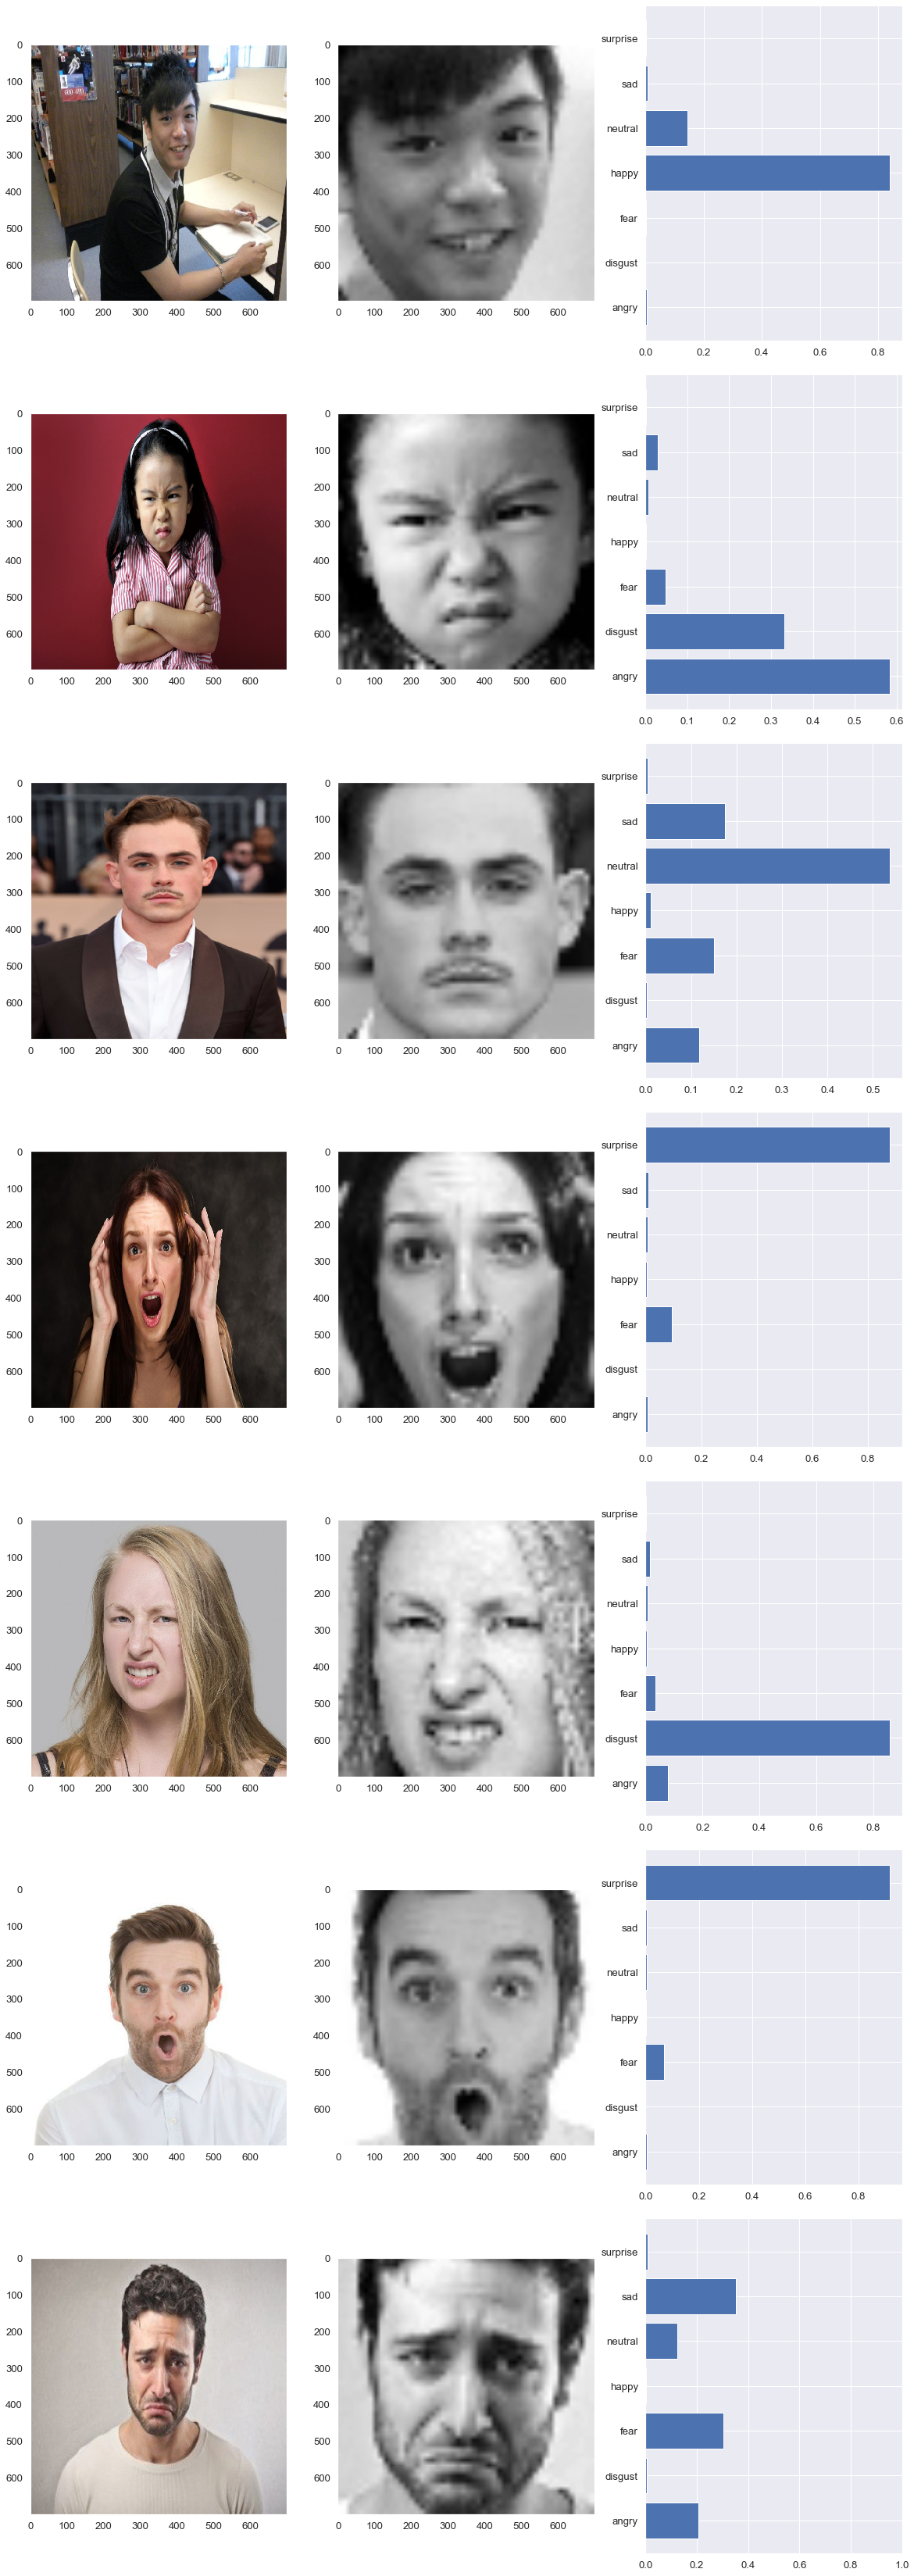

In [12]:
fig, ax = plt.subplots(7, 3,figsize=(20, 60))

for i in range (0,7):
    
# Origin Image
        image = plt.imread(path[i])
        ax[i,0].imshow(cv2.resize(image,(700, 700)))
        ax[i,0].grid(False)
        
# Frontal Face Image
        img = cv2.imread(path[i],cv2.IMREAD_GRAYSCALE)
        faces_rect,test_img=faceDetection(img)
        (x,y,w,h)=faces_rect[0]
        roi_gray=test_img[y:y+w,x:x+h]
        new_array = cv2.resize(roi_gray,(img_rows, img_cols))
        ax[i,1].imshow(cv2.resize(new_array,(700, 700)),cmap = 'gray')
        ax[i,1].grid(False)
    
# Prediction Bar Graph 
        x_img = new_array.reshape(1, img_rows, img_cols, 1)
        a_img = x_img.astype('float32')
        a_img /= 255
        predict = CNN_model.predict(a_img)
        predict_prob = CNN_model.predict_proba(a_img)
        pltx = pd.DataFrame(Type)
        pltx = pltx.rename(columns={ 0 : "Type"})
        plty = pd.DataFrame(predict_prob).T
        plty = plty.rename(columns={ 0 : "Precent"});
        ans = pd.concat([pltx, plty],axis =1)
        ax[i,2].barh(ans['Type'],ans['Precent'])
        plt.xlim(0,1)

plt.subplots_adjust(wspace=0.2, hspace=0.1)